In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Cross validation

Cross validation (CV) is one of the most important techniques in the data scientist's toolbox.

Operationally, CV implements different training and test sets (here called **validation**), effectively creating different models trained and evaluated on different random subsets (the so-called **folds**) of the original database.

In the end, it is possible to inspect the metrics of interest in each fold, as well as to have an idea of the average performance of the model, looking at **the distribution of the evaluation metrics**. Note that this procedure is closely related to the evaluation of the desirable ability of **model generalization**.

The most common way to do CV is through the **k-fold** technique:

<img src=https://scikit-learn.org/stable/_images/grid_search_cross_validation.png width=500>

In the extreme of this approach, we can take the number $k$ of folds equal to the number of observations in the database ($n$). In this case, **a single** observation is used for testing, while the rest of the dataset is used for training. This approach is known as **leave one out (LOO)**:

<img src=https://assets.datacamp.com/production/repositories/3981/datasets/8a6236f142b1ee2e4a70aae2af9507c7c580f302/Screen%20Shot%202019-01-27%20at%209.25.41%20AM.png width=500>

Note that the computational effort increases as $k$ increases, being maximum when $k=n$. For this reason, it is recommended to use LOO only in cases where the number of observations in the original database is very small ($\sim 10^2$).

To implement the CV procedure using sklearn, in the [model_selection submodule](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection), we have two very important tools for the CV process:

- [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold): class to create folds. Note: to do LOO, just put $k=n$ folds, or else use the class that implements [LOO](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut);

- [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate): function that receives the folds and uses them for cross-training and evaluation of models, according to the defined metric.

To illustrate CV, we will use the artificial datasets that sklearn provides:

In [2]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples = 500,
                        n_features = 5, n_informative = 3, 
                        noise = 25, tail_strength = 10,
                        random_state = 42)

In [3]:
X_df = pd.DataFrame(X, columns=[f"X{i+1}" for i in range(X.shape[1])])
y_df = pd.Series(y, name="y")
df = pd.concat([X_df, y_df], axis=1)
df.head()

,X1,X2,X3,X4,X5,y
0,-0.109610,0.546284,-0.088363,0.006422,-0.436386,79.870807
1,-1.024388,-0.926930,-0.252568,-0.059525,-3.241267,-115.324859
2,-2.650970,0.106430,1.091507,-0.254977,1.503993,35.552509
3,-0.850520,-0.138456,-0.580523,-1.224298,-0.209023,-145.413703
4,-0.322680,-0.756795,-0.250833,-1.421811,1.501334,-116.148875


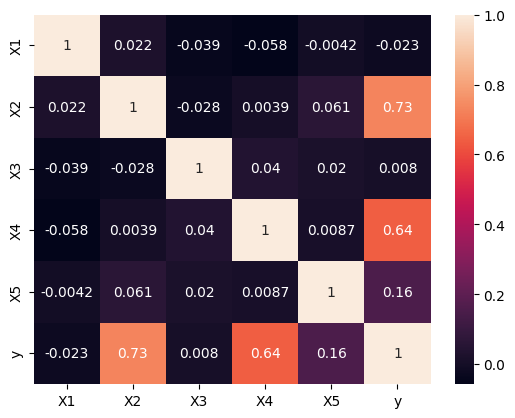

In [4]:
sns.heatmap(df.corr(), annot=True);

The data do not have such a large scale variation, so we will not worry about normalizing them, in case we want to use regularization. **But never forget that this is very important when there are large scale differences**.

Now, let's implement CV:


In [5]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [6]:
# number of splits
len(list(kf.split(X)))

5

In [7]:
# in each split, we have a tuple ([train indices], [validation indices])
train_ix, val_ix = list(kf.split(X))[0]

In [9]:
train_ix.shape, val_ix.shape

((400,), (100,))

In [11]:
train_ix[:10]

array([ 1,  3,  4,  5,  6,  7,  8, 10, 12, 13])

In [12]:
val_ix[:10]

array([ 0,  2,  9, 11, 15, 18, 22, 30, 33, 39])

As seen above, the KFold class only generates the splits. But, in practice, we will use `cross_validate()`, which has KFold as an argument.

In [13]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import ElasticNet

In [14]:
en = ElasticNet()
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)

result_cv = cross_validate(estimator=en, X=X, y=y, 
                           cv=kf5, scoring="neg_mean_absolute_error",
                           return_train_score=True)

df_result_cv = pd.DataFrame(result_cv).abs()
df_result_cv

,fit_time,score_time,test_score,train_score
0,0.004953,0.000632,37.242368,34.538921
1,0.000425,0.000161,36.915451,34.920248
2,0.000514,0.000173,33.870163,35.329187
3,0.000299,0.000250,33.954736,35.498673
4,0.000598,0.000234,33.573468,34.382697


Cross-validation applied to classification problems:

In [15]:
from sklearn.datasets import make_classification

X_clf, y_clf = make_classification(n_samples=500,
                                 n_features=5, n_informative=3,
                                 n_classes=2,
                                 random_state=42)

X_clf_df = pd.DataFrame(X_clf, columns=[f'X{i+1}' for i in range(X_clf.shape[1])]) 
y_clf_df = pd.Series(y_clf, name="y")    
df_clf = pd.concat([X_clf_df, y_clf_df], axis=1)
df_clf.head()

,X1,X2,X3,X4,X5,y
0,0.280056,-1.126421,-0.772964,2.060626,-2.357044,0
1,-0.326002,0.343967,1.535987,-1.794578,1.293605,1
2,-0.802972,-1.112616,-1.088524,0.668720,-1.183952,0
3,0.012285,-0.350602,-1.359103,1.234112,-0.909008,0
4,0.043145,-1.077267,-0.873334,1.727960,-2.031498,0


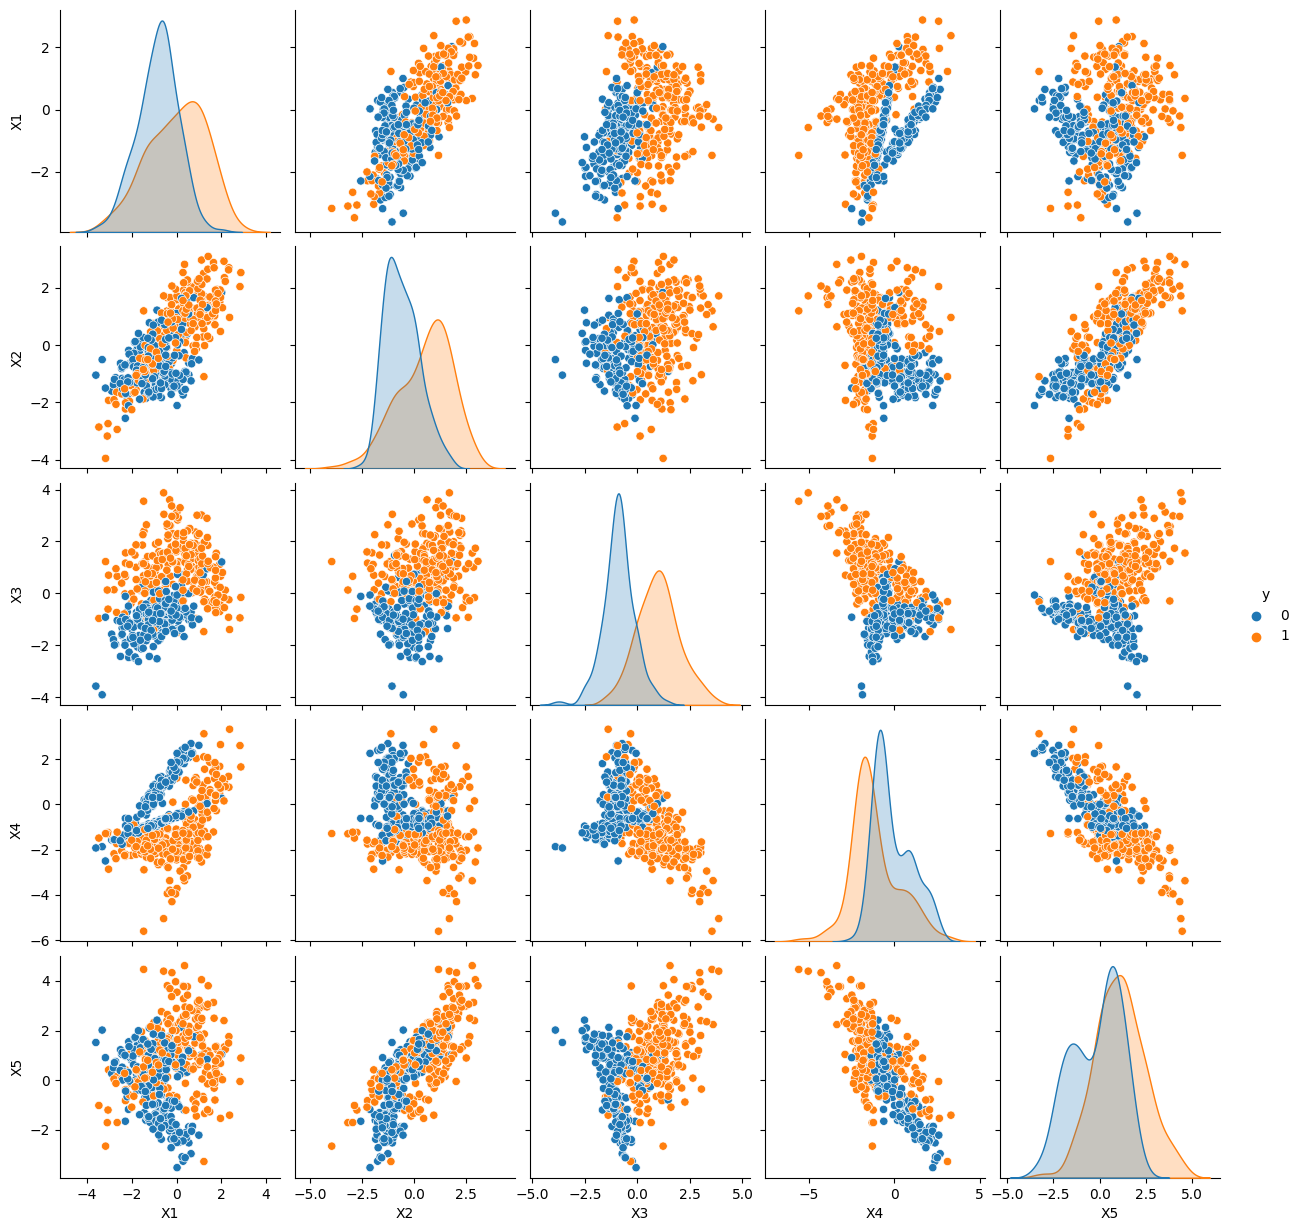

In [17]:
sns.pairplot(df_clf, hue="y");

## Hiperparameter tuning

Besides allowing a more robust evaluation of a model, CV can also be used for a very important purpose: **the choice of adequate values of hyperparameters** of a model -- a process known as **hyperparameter tuning**.

<img src=https://www.okw.com/en/Com-Knobs/COM-KNOBS-class-OKW_GroupInfoImage500x408.jpg width=400>

When testing different values / combinations of hyperparameters in different folds, we have a more realistic estimate of the effect of these choices: if the result is good in all folds (or good on average), we have a more robust indication that that is indeed a good choice. In particular, it becomes much more difficult to commit **overfitting** by choosing hyperparameters that fit a single training base very well.

To learn more about these issues, check [this post](https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d) and [this post](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/).

In SKLearn, we have the CV procedure incorporated into some hypothesis classes:

- [Lasso CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)
- [Ridge CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)
- [ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)
- [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)

In all cases, it is possible to specify a list of hyperparameters to be traversed, and the model with the best hyperparameter (or combination of hyperparameters) is chosen.

In [23]:
from sklearn.linear_model import LassoCV

kf5 = KFold(n_splits=10, shuffle=True, random_state=42)
l1 = LassoCV(alphas=np.linspace(0.1, 1, 100), cv=kf5).fit(X, y)

In [24]:
l1

LassoCV(alphas=array([0.1       , 0.10909091, 0.11818182, 0.12727273, 0.13636364,
       0.14545455, 0.15454545, 0.16363636, 0.17272727, 0.18181818,
       0.19090909, 0.2       , 0.20909091, 0.21818182, 0.22727273,
       0.23636364, 0.24545455, 0.25454545, 0.26363636, 0.27272727,
       0.28181818, 0.29090909, 0.3       , 0.30909091, 0.31818182,
       0.32727273, 0.33636364, 0.34545455, 0.35454545, 0.36363636,
       0.37272727, 0.381818...
       0.73636364, 0.74545455, 0.75454545, 0.76363636, 0.77272727,
       0.78181818, 0.79090909, 0.8       , 0.80909091, 0.81818182,
       0.82727273, 0.83636364, 0.84545455, 0.85454545, 0.86363636,
       0.87272727, 0.88181818, 0.89090909, 0.9       , 0.90909091,
       0.91818182, 0.92727273, 0.93636364, 0.94545455, 0.95454545,
       0.96363636, 0.97272727, 0.98181818, 0.99090909, 1.        ]),
        cv=KFold(n_splits=10, random_state=42, shuffle=True))

In [25]:
l1.alpha_

0.4545454545454546